---
This notebook generates image variants from the vanilla SVG cards.

---

In [81]:
import multiprocessing
import os
import random
import sys
import numpy as np
from PIL import Image, ImageFilter


# Setup input and output directories.
input_directory = 'card-images'
output_directories = ('rgba-images', 'greyscaled-images', 'rgba-data', 'greyscaled-data')
for output_directory in output_directories:
  if not os.path.exists(output_directory):
    os.makedirs(output_directory)
  
# Cropping and resizing params.
original_card_width, original_card_height = 352, 550
card_width, card_height = 150, 150

# White balance, rotation and blur params.
min_channel_high_end = 0.4
max_channel_low_end = 0.4
max_rotation = 10
max_blur = 3

# Seed the rng.
random.seed(2)


def preprocess(input_path):
  """Preprocess images."""
  # Load.
  image = Image.open(input_path)
  
  # Crop.
  image = image.crop((0, 0, original_card_width, original_card_height))
  
  # Adjust white balance.
  rmin = random.random()*min_channel_high_end
  gmin = random.random()*min_channel_high_end
  bmin = random.random()*min_channel_high_end
  rmax = random.random()*max_channel_low_end + 1 - max_channel_low_end
  gmax = random.random()*max_channel_low_end + 1 - max_channel_low_end
  bmax = random.random()*max_channel_low_end + 1 - max_channel_low_end
  new_image = np.empty((original_card_height, original_card_width, 3), dtype=np.float32)
  image = np.multiply(np.array(image), 1/255.)
  new_image[:, :, 0] = np.add(np.multiply(image[:, :, 0], (rmax-rmin)), rmin)
  new_image[:, :, 1] = np.add(np.multiply(image[:, :, 1], (gmax-gmin)), gmin)
  new_image[:, :, 2] = np.add(np.multiply(image[:, :, 2], (bmax-bmin)), bmin)
  new_image = np.multiply(new_image, 255)
  image = Image.fromarray(np.uint8(new_image))
    
  # Rotate.
  rotation = random.choice([-1, 1]) * max_rotation * random.random()
  image = image.rotate(rotation, expand=True, resample=Image.BICUBIC)
  
  # Resize.
  image = image.resize((card_width, card_height), resample=Image.ANTIALIAS)
  
  # Blur.
  blur = max_blur * random.random()
  image = image.filter(ImageFilter.GaussianBlur(blur))
  
  # Greyscale.
  greyscaled_image = image.convert('L')
  
  # Get data.
  rgba_data = np.array(image).flatten()
  greyscaled_data = np.array(greyscaled_image).flatten()
  
  # Parse the input path.
  filename = input_path.split('/')[-1]
  number = filename.split('-')[0]
  color = filename.split('-')[1]
  texture = filename.split('-')[2]
  shape = filename.split('-')[3].split('.png')[0]
  
  # Save.
  output_filename_base = '%s-%s-%s-%s' % (number, color, texture, shape)
  output_filename_base += '-%0.2frmin-%0.2fgmin-%0.2fbmin-%0.2frmax-%0.2fgmax-%0.2fbmax' % (
    rmin, gmin, bmin, rmax, gmax, bmax)
  output_filename_base += '-%0.2fdeg' % rotation
  output_filename_base += '-%0.2fblur' % blur
  rgba_image_path = os.path.join('rgba-images', '%s.png' % output_filename_base)
  image.save(rgba_image_path)
  greyscaled_image_path = os.path.join('greyscaled-images', '%s.png' % output_filename_base)
  greyscaled_image.save(greyscaled_image_path)
  rgba_data_path = os.path.join('rgba-data', '%s.png' % output_filename_base)
  np.save(rgba_data_path, rgba_data)
  greyscaled_data_path = os.path.join('greyscaled-data', '%s.png' % output_filename_base)
  np.save(greyscaled_data_path, greyscaled_data)


# Input params.
image_paths = [os.path.join(input_directory, f) for f in os.listdir(input_directory)]
variations_per_image = 3

for image_path in image_paths:
  for _ in range(variations_per_image):
    preprocess(image_path)
  
# Run it.
'''
print 'generating %s images..' % len(inputs)
pool = multiprocessing.Pool()
for i, _ in enumerate(pool.imap_unordered(preprocess, inputs, 1)):
  sys.stdout.write('\r%0.1f%% complete..' % (100. * i / len(inputs)))
pool.close()
pool.join()
sys.stdout.write('\r100% complete.')
'''

"\nprint 'generating %s images..' % len(inputs)\npool = multiprocessing.Pool()\nfor i, _ in enumerate(pool.imap_unordered(preprocess, inputs, 1)):\n  sys.stdout.write('\r%0.1f%% complete..' % (100. * i / len(inputs)))\npool.close()\npool.join()\nsys.stdout.write('\r100% complete.')\n"

---
Display a few.

---

3-red-striped-diamond-0.39rmin-0.39gmin-0.33bmin-0.86rmax-0.91gmax-0.94bmax--6.27deg-2.95blur.png


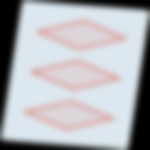

2-green-solid-diamond-0.34rmin-0.18gmin-0.27bmin-0.82rmax-0.81gmax-0.78bmax-7.55deg-1.26blur.png


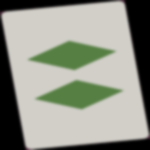

1-purple-striped-diamond-0.38rmin-0.14gmin-0.19bmin-0.96rmax-0.67gmax-0.98bmax--0.28deg-1.05blur.png


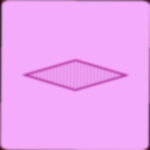

3-purple-empty-diamond-0.39rmin-0.30gmin-0.16bmin-0.93rmax-0.84gmax-0.84bmax-7.53deg-2.13blur.png


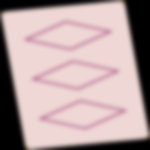

1-green-striped-oval-0.19rmin-0.30gmin-0.16bmin-0.65rmax-0.65gmax-0.63bmax-6.41deg-2.88blur.png


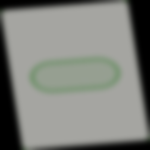

2-green-striped-bean-0.09rmin-0.24gmin-0.07bmin-0.72rmax-0.93gmax-0.83bmax-4.65deg-0.84blur.png


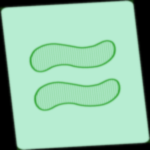

1-purple-empty-bean-0.11rmin-0.21gmin-0.19bmin-0.98rmax-0.92gmax-0.97bmax-2.97deg-0.69blur.png


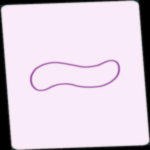

1-green-empty-oval-0.20rmin-0.21gmin-0.26bmin-0.84rmax-0.72gmax-0.68bmax-9.34deg-1.87blur.png


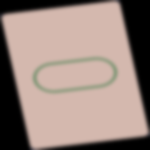

2-purple-solid-bean-0.27rmin-0.15gmin-0.17bmin-0.91rmax-0.69gmax-0.71bmax-9.05deg-0.26blur.png


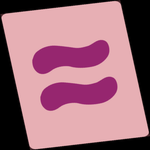

2-red-striped-diamond-0.20rmin-0.14gmin-0.03bmin-0.77rmax-0.82gmax-0.94bmax--2.88deg-0.01blur.png


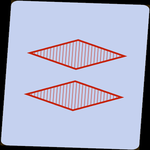

In [84]:
from IPython import display

output_directory = 'rgba-images'
images = random.sample(os.listdir(output_directory), 10)
for filename in images:
  print filename
  path = os.path.join(output_directory, filename)
  display.display(display.Image(filename=path))